## Config

In [1]:
from __future__ import division
from __future__ import print_function

import time


class CONFIG(object):
    """docstring for CONFIG"""
    def __init__(self):
        super(CONFIG, self).__init__()

        self.dataset = 'R8'
        self.model = 'gcn' # 'gcn', 'gcn_cheby', 'dense'
        self.learning_rate = 0.02 # Initial learning rate
        self.epochs = 200 # Number of epochs to train
        self.hidden1 = 200 # Number of units in hidden layer 1
        self.dropout = 0.5 # Dropout rate (1 - keep probability)
        self.weight_decay = 0. # Weight for L2 loss on embedding matrix
        self.early_stopping = 10 # Tolerance for early stopping (# of epochs)
        self.max_degree = 3 # Maximum Chebyshev polynomial degree.

## Utils

In [10]:
import re
import sys
import numpy as np
import pickle as pkl
import networkx as nx
import scipy.sparse as sp
from scipy.sparse.linalg import eigsh

def parse_index_file(filename):
    """Parse index file"""
    index = []
    for line in open(filename):
        index.append(int(line.strip()))
    return index

def sample_mask(idx, l):
    """Create mask"""
    mask = np.zeros(l)
    mask[idx] = 1
    return np.array(mask, dtype=np.bool)

def load_data(dataset_str):
    names = ['x', 'y', 'tx', 'ty', 'allx', 'ally', 'graph']
    objects = []
    for i in range(len(names)):
        with open("data/ind.{}.{}".format(dataset_str, names[i]), 'rb') as f:
            if sys.version_info > (3, 0):
                objects.append(pkl.load(f, encoding='latin1'))
            else:
                objects.append(pkl.load(f))

    x, y, tx, ty, allx, ally, graph = tuple(objects)
    test_idx_reorder = parse_index_file("data/ind.{}.test.index".format(dataset_str))
    test_idx_range = np.sort(test_idx_reorder)
    print_log(x.shape, y.shape, tx.shape, ty.shape, allx.shape, ally.shape)

    if dataset_str == "citeseer":
        # Fix citeseer dataset (there are some isolated nodes in the graph)
        # Find isolated nodes, add them as zero-vecs into the right position
        test_idx_range_full = range(
            min(test_idx_reorder), max(test_idx_reorder)+1)
        tx_extended = sp.lil_matrix((len(test_idx_range_full), x.shape[1]))
        tx_extended[test_idx_range-min(test_idx_range), :] = tx
        tx = tx_extended
        ty_extended = np.zeros((len(test_idx_range_full), y.shape[1]))
        ty_extended[test_idx_range-min(test_idx_range), :] = ty
        ty = ty_extended

    features = sp.vstack((allx, tx)).tolil()
    features[test_idx_reorder, :] = features[test_idx_range, :]
    adj = nx.adjacency_matrix(nx.from_dict_of_lists(graph))

    labels = np.vstack((ally, ty))
    labels[test_idx_reorder, :] = labels[test_idx_range, :]

    idx_test = test_idx_range.tolist()
    idx_train = range(len(y))
    idx_val = range(len(y), len(y)+500)

    train_mask = sample_mask(idx_train, labels.shape[0])
    val_mask = sample_mask(idx_val, labels.shape[0])
    test_mask = sample_mask(idx_test, labels.shape[0])

    y_train = np.zeros(labels.shape)
    y_val = np.zeros(labels.shape)
    y_test = np.zeros(labels.shape)
    y_train[train_mask, :] = labels[train_mask, :]
    y_val[val_mask, :] = labels[val_mask, :]
    y_test[test_mask, :] = labels[test_mask, :]

    return adj, features, y_train, y_val, y_test, train_mask, val_mask, test_mask

def load_corpus(dataset_str):
    names = ['x', 'y', 'tx', 'ty', 'allx', 'ally', 'adj']
    objects = []
    for i in range(len(names)):
        with open("./data/ind.{}.{}".format(dataset_str, names[i]), 'rb') as f:
            if sys.version_info > (3, 0):
                objects.append(pkl.load(f, encoding='latin1'))
            else:
                objects.append(pkl.load(f))

    x, y, tx, ty, allx, ally, adj = tuple(objects)

    features = sp.vstack((allx, tx)).tolil()
    labels = np.vstack((ally, ty))

    train_idx_orig = parse_index_file(
        "./data/{}.train.index".format(dataset_str)
    )
    train_size = len(train_idx_orig)

    val_size = train_size - x.shape[0]
    test_size = tx.shape[0]

    idx_train = range(len(y))
    idx_val = range(len(y), len(y) + val_size)
    idx_test = range(allx.shape[0], allx.shape[0] + test_size)

    train_mask = sample_mask(idx_train, labels.shape[0])
    val_mask = sample_mask(idx_val, labels.shape[0])
    test_mask = sample_mask(idx_test, labels.shape[0])

    y_train = np.zeros(labels.shape)
    y_val = np.zeros(labels.shape)
    y_test = np.zeros(labels.shape)
    y_train[train_mask, :] = labels[train_mask, :]
    y_val[val_mask, :] = labels[val_mask, :]
    y_test[test_mask, :] = labels[test_mask, :]

    adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj)

    return adj, features, y_train, y_val, y_test, train_mask, val_mask, test_mask, train_size, test_size

def sparse_to_tuple(sparse_mx):
    """Convert sparse matrix to tuple representation"""
    def to_tuple(mx):
        if not sp.isspmatrix_coo(mx):
            mx = mx.tocoo()
        coords = np.vstack((mx.row, mx.col)).transpose()
        values = mx.data
        shape = mx.shape
        return coords, values, shape

    if isinstance(sparse_mx, list):
        for i in range(len(sparse_mx)):
            sparse_mx[i] = to_tuple(sparse_mx[i])
    else:
        sparse_mx = to_tuple(sparse_mx)
    return sparse_mx

def preprocess_features(features):
    """Row-normalized feature matrix and convert to tuple representation"""
    rowsum = np.array(features.sum(1))
    r_inv = np.power(rowsum, -1).flatten()
    r_inv[np.isinf(r_inv)] = 0.
    r_mat_inv = sp.diags(r_inv)
    features = r_mat_inv.dot(features)
    return features.A

def normalize_adj(adj):
    """Symetrically normalize adjacency matrix"""
    adj = sp.coo_matrix(adj)
    rowsum = np.array(adj.sum(1))
    d_inv_sqrt = np.power(rowsum, -0.5).flatten()
    d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0.
    d_mat_inv_sqrt = sp.diags(d_inv_sqrt)
    return adj.dot(d_mat_inv_sqrt).transpose().dot(d_mat_inv_sqrt).tocoo()

def preprocess_adj(adj):
    """Preprocessing of adjacency matrix for simple GCN model and conversion to tuple representation."""
    adj_normalized = normalize_adj(adj + sp.eye(adj.shape[0]))
    return adj_normalized.A

def construct_feed_dict(features, support, labels, labels_mask, placeholders):
    """Construct feed dictionary"""
    feed_dict = dict()
    feed_dict.update({placeholders['labels']: labels})
    feed_dict.update({placeholders['labels_mask']: labels_mask})
    feed_dict.update({placeholders['features']: features})
    feed_dict.update({placeholders['support'][i]: support[i] for i in range(len(len(support)))})
    feed_dict.update({placeholders['num_features_nonzero']: features[1].shape})
    return feed_dict

def chebyshev_polynomials(adj, k):
    """Calculate Chebyshev polynomials up to order k. Return a list of sparse matrix (tuple representation)"""
    print_log("Calculating Chebyshev polynomials up to order {}...".format(k))

    adj_normalized = normalize_adj(adj)
    laplacian = sp.eye(adj.shape[0]) - adj_normalized
    largest_eigval, _ = eigsh(laplacian, 1, which='LM')
    scaled_laplacian = (2. / largest_eigval[0]) * laplacian - sp.eye(adj.shape[0])

    t_k = list()
    t_k.append(sp.eye(adj.shape[0]).A)
    t_k.append(scaled_laplacian.A)

    def chebyshev_recurrence(t_k_minus_one, t_k_minus_two, scaled_lap):
        s_lap = sp.csr_matrix(scaled_lap, copy=True)
        return 2 * s_lap.dot(t_k_minus_one) - t_k_minus_two

    for i in range(2, k+1):
        t_k.append(chebyshev_recurrence(t_k[-1], t_k[-2], scaled_laplacian))

    return t_k

def loadWord2Vec(filename):
    """Read Word Vectors"""
    vocab = []
    embd = []
    word_vector_map = {}
    file = open(filename, 'r')
    for line in file.readlines():
        row = line.strip().split(' ')
        if (len(row) > 2):
            vocab.append(row[0])
            vector = row[1:]
            length = len(vector)
            for i in range(length):
                vector[i] = float(vector[i])
            embd.append(vector)
            word_vector_map[row[0]] = vector
    print_log('Loaded Word Vectors!')
    file.close()
    return vocab, embd, word_vector_map

def clean_str(string):
    """
    Tokenization/string cleaning for all datasets except for SST.
    Original taken from https://github.com/yoonkim/CNN_sentence/blob/master/process_data.py
    """
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    return string.strip().lower()

import datetime
def print_log(msg='', end='\n'):
    now = datetime.datetime.now()
    t = str(now.year) + '/' + str(now.month) + '/' + str(now.day) + ' '\
        + str(now.hour).zfill(2) + ':' + str(now.minute).zfill(2) + ':' + str(now.second).zfill(2)

    if isinstance(msg, str):
        lines = msg.split('\n')
    else:
        lines = [msg]

    for line in lines:
        if line == lines[-1]:
            print('[' + t + '] ' + str(line), end=end)
        else:
            print('[' + t + '] ' + str(line))

## Preprocess

In [4]:
# remove words
import sys
import nltk
from nltk.wsd import lesk
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn

datasets = ['20ng', 'R8', 'R52', 'ohsumed', 'mr']
dataset = "R8"

if dataset not in datasets:
    sys.exit("wrong dataset name")

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
print(stop_words)

doc_content_list = []
with open('./data/corpus/' + dataset + '.txt', 'rb') as f:
    for line in f.readlines():
        doc_content_list.append(line.strip().decode('latin1'))

word_freq = {}
for doc_content in doc_content_list:
    temp = clean_str(doc_content)
    words = temp.split()
    for word in words:
        if word in word_freq:
            word_freq[word] += 1
        else:
            word_freq[word] = 1

clean_docs = []
for doc_content in doc_content_list:
    temp = clean_str(doc_content)
    words = temp.split()
    doc_words = []
    for word in words:
        # word not in stop_words and word_freq[word] >= 5
        if datasets == 'mr':
            doc_words.append(word)
        elif word not in stop_words and word_freq[word] >= 5:
            doc_words.append(word)

    doc_str = ' '.join(doc_words).strip()
    clean_docs.append(doc_str)

clean_corpus_str = '\n'.join(clean_docs)

with open('./data/corpus/' + dataset + '.clean.txt', 'w') as f:
    f.write(clean_corpus_str)

max_len = 0
aver_len = 0
min_len = 10000

with open('./data/corpus/' + dataset + '.clean.txt', 'r') as f:
    lines = f.readlines()
    for line in lines:
        line = line.strip()
        temp = line.split()
        aver_len = aver_len + len(temp)
        if len(temp) < min_len:
            min_len = len(temp)
        if len(temp) > max_len:
            max_len = len(temp)

aver_len = 1.0 * aver_len / len(lines)
print('min_len : ' + str(min_len))
print('max_len : ' + str(max_len))
print('average_len : ' + str(aver_len))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\firqa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


{'own', 'them', 'themselves', 'doing', 'can', 'hers', "shouldn't", "you've", 'be', 'some', 'doesn', 'through', 'his', "isn't", 'very', 'your', 'have', 'wasn', 'nor', 'is', 'than', 'it', 'himself', 't', 'from', 'under', 'their', 'couldn', 'won', 'all', 'those', 'he', 'about', 'been', 'me', 'haven', 'are', "didn't", 'shouldn', 'has', 'no', 'hadn', 'ain', 'on', 'do', 'yourself', 'itself', 'were', 'ours', 'down', 'don', 'should', 'myself', 'to', 'off', 'my', 'him', 'other', "don't", 've', "wasn't", 'only', 'yours', 'for', "should've", 'you', "mightn't", 'against', 'most', 'until', 'd', 'up', 'more', 'they', 'or', 'when', 'this', 'needn', 'a', 'will', 'mustn', 'o', 's', "couldn't", "you'll", "you're", 'not', 'we', 'after', 'aren', 'of', 'the', "that'll", "weren't", 'further', 'who', 'same', 'shan', 'am', 'its', 'why', 'just', 'before', 'weren', "needn't", "hasn't", 'ma', 'being', 'ourselves', 'y', 'in', 'm', 'what', 'yourselves', 'mightn', 'was', 'over', "she's", 'because', "aren't", 'again

In [5]:
# build graph
import os
import sys
import random
import numpy as np
import pickle as pkl
from math import log
from sklearn import svm
import scipy.sparse as sp
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.spatial.distance import cosine

datasets = ['20ng', 'R8', 'R52', 'ohsumed', 'mr']
dataset = "R8"

if dataset not in datasets:
    sys.exit("wrong dataset name")

word_embedding_dim = 300
word_vector_map = {}

# Shuffling
doc_name_list = []
doc_train_list = []
doc_test_list = []

with open("./data/" + dataset + '.txt', 'r') as f:
    lines = f.readlines()
    for line in lines:
        doc_name_list.append(line.strip())
        temp = line.split("\t")
        if temp[1].find("test") != -1:
            doc_test_list.append(line.strip())
        elif temp[1].find('train') != -1:
            doc_train_list.append(line.strip())

doc_content_list = []
with open("./data/corpus/" + dataset + '.clean.txt', 'r') as f:
    lines = f.readlines()
    for line in lines:
        doc_content_list.append(line.strip())

train_ids = []
for train_name in doc_train_list:
    train_id = doc_name_list.index(train_name)
    train_ids.append(train_id)
print(train_ids)
random.shuffle(train_ids)

train_ids_str = "\n".join(str(index) for index in train_ids)
with open("./data/" + dataset + '.train.index', 'w') as f:
    f.write(train_ids_str)

test_ids = []
for test_name in doc_test_list:
    test_id = doc_name_list.index(test_name)
    test_ids.append(test_id)
print(test_ids)
random.shuffle(test_ids)

test_ids_str = "\n".join(str(index) for index in test_ids)
with open("./data/" + dataset + ".test.index", "w") as f:
    f.write(test_ids_str)

ids = train_ids + test_ids
print(ids)
print(len(ids))

shuffle_doc_name_list = []
shuffle_doc_words_list = []
for id in ids:
    shuffle_doc_name_list.append(doc_name_list[int(id)])
    shuffle_doc_words_list.append(doc_content_list[int(id)])
shuffle_doc_name_str = "\n".join(shuffle_doc_name_list)
shuffle_doc_words_str = "\n".join(shuffle_doc_words_list)

with open("./data/" + dataset + "_shuffle.txt", "w") as f:
    f.write(shuffle_doc_name_str)

with open("./data/corpus/" + dataset + "_shuffle.txt", "w") as f:
    f.write(shuffle_doc_words_str)

# build vocab
word_freq = {}
word_set = set()
for doc_words in shuffle_doc_words_list:
    words = doc_words.split()
    for word in words:
        word_set.add(word)
        if word in word_freq:
            word_freq[word] += 1
        else:
            word_freq[word] = 1

vocab = list(word_set)
vocab_size = len(vocab)

word_doc_list = {}

for i in range(len(shuffle_doc_words_list)):
    doc_words = shuffle_doc_words_list[i]
    words = doc_words.split()
    appeared = set()
    for word in words:
        if word in appeared:
            continue
        if word in word_doc_list:
            doc_list = word_doc_list[word]
            doc_list.append(i)
            word_doc_list[word] = doc_list
        else:
            word_doc_list[word] = [i]
        appeared.add(word)

word_doc_freq = {}
for word, doc_list in word_doc_list.items():
    word_doc_freq[word] = len(doc_list)

word_id_map = {}
for i in range(vocab_size):
    word_id_map[vocab[i]] = i

vocab_str = "\n".join(vocab)

with open("./data/corpus/" + dataset + "_vocab.txt", "w") as f:
    f.write(vocab_str)

# Label List
label_set = set()
for doc_meta in shuffle_doc_name_list:
    temp = doc_meta.split('\t')
    label_set.add(temp[2])
label_list = list(label_set)

label_list_str = '\n'.join(label_list)
with open('./data/corpus/' + dataset + '_labels.txt', 'w') as f:
    f.write(label_list_str)

train_size = len(train_ids)
val_size = int(0.1 * train_size)
real_train_size = train_size - val_size

real_train_doc_names = shuffle_doc_name_list[:real_train_size]
real_train_doc_names_str = '\n'.join(real_train_doc_names)

with open('./data/' + dataset + '.real_train.name', 'w') as f:
    f.write(real_train_doc_names_str)

row_x = []
col_x = []
data_x = []
for i in range(real_train_size):
    doc_vec = np.array([0.0 for k in range(word_embedding_dim)])
    doc_words = shuffle_doc_words_list[i]
    words = doc_words.split()
    doc_len = len(words)
    for word in words:
        if word in word_vector_map:
            word_vector = word_vector_map[word]
            doc_vec = doc_vec + np.array(word_vector)

    for j in range(word_embedding_dim):
        row_x.append(i)
        col_x.append(j)
        data_x.append(doc_vec[j] / doc_len)

x = sp.csr_matrix((data_x, (row_x, col_x)), shape=(real_train_size, word_embedding_dim))

y = []
for i in range(real_train_size):
    doc_meta = shuffle_doc_name_list[i]
    temp = doc_meta.split('\t')
    label = temp[2]
    one_hot = [0 for l in range(len(label_list))]
    label_index = label_list.index(label)
    one_hot[label_index] = 1
    y.append(one_hot)
y = np.array(y)
print(y)

# tx: feature vectors of test docs, no initial features
test_size = len(test_ids)

row_tx = []
col_tx = []
data_tx = []
for i in range(test_size):
    doc_vec = np.array([0.0 for k in range(word_embedding_dim)])
    doc_words = shuffle_doc_words_list[i + train_size]
    words = doc_words.split()
    doc_len = len(words)
    for word in words:
        if word in word_vector_map:
            word_vector = word_vector_map[word]
            doc_vec = doc_vec + np.array(word_vector)

    for j in range(word_embedding_dim):
        row_tx.append(i)
        col_tx.append(j)
        data_tx.append(doc_vec[j] / doc_len)

tx = sp.csr_matrix((data_tx, (row_tx, col_tx)),
                   shape=(test_size, word_embedding_dim))

ty = []
for i in range(test_size):
    doc_meta = shuffle_doc_name_list[i + train_size]
    temp = doc_meta.split('\t')
    label = temp[2]
    one_hot = [0 for l in range(len(label_list))]
    label_index = label_list.index(label)
    one_hot[label_index] = 1
    ty.append(one_hot)
ty = np.array(ty)
print(ty)

# allx: the the feature vectors of both labeled and unlabeled training instances
# (a superset of x)
# unlabeled training instances -> words

word_vectors = np.random.uniform(-0.01, 0.01, (vocab_size, word_embedding_dim))

for i in range(len(vocab)):
    word = vocab[i]
    if word in word_vector_map:
        vector = word_vector_map[word]
        word_vectors[i] = vector

row_allx = []
col_allx = []
data_allx = []

for i in range(train_size):
    doc_vec = np.array([0.0 for k in range(word_embedding_dim)])
    doc_words = shuffle_doc_words_list[i]
    words = doc_words.split()
    doc_len = len(words)
    for word in words:
        if word in word_vector_map:
            word_vector = word_vector_map[word]
            doc_vec = doc_vec + np.array(word_vector)
    for j in range(word_embedding_dim):
        row_allx.append(int(i))
        col_allx.append(j)
        data_allx.append(doc_vec[j] / doc_len)
for i in range(vocab_size):
    for j in range(word_embedding_dim):
        row_allx.append(int(i + train_size))
        col_allx.append(j)
        data_allx.append(word_vectors.item((i, j)))

row_allx = np.array(row_allx)
col_allx = np.array(col_allx)
data_allx = np.array(data_allx)

allx = sp.csr_matrix((data_allx, (row_allx, col_allx)), shape=(train_size + vocab_size, word_embedding_dim))

ally = []
for i in range(train_size):
    doc_meta = shuffle_doc_name_list[i]
    temp = doc_meta.split('\t')
    label = temp[2]
    one_hot = [0 for l in range(len(label_list))]
    label_index = label_list.index(label)
    one_hot[label_index] = 1
    ally.append(one_hot)

for i in range(vocab_size):
    one_hot = [0 for l in range(len(label_list))]
    ally.append(one_hot)

ally = np.array(ally)
print(x.shape, y.shape, tx.shape, ty.shape, allx.shape, ally.shape)

'''
Doc word heterogeneous graph
'''

# word co-occurence with context windows
window_size = 20
windows = []

for doc_words in shuffle_doc_words_list:
    words = doc_words.split()
    length = len(words)
    if length <= window_size:
        windows.append(words)
    else:
        for j in range(length - window_size + 1):
            window = words[j: j + window_size]
            windows.append(window)

word_window_freq = {}
for window in windows:
    appeared = set()
    for i in range(len(window)):
        if window[i] in appeared:
            continue
        if window[i] in word_window_freq:
            word_window_freq[window[i]] += 1
        else:
            word_window_freq[window[i]] = 1
        appeared.add(window[i])

word_pair_count = {}
for window in windows:
    for i in range(1, len(window)):
        for j in range(0, i):
            word_i = window[i]
            word_i_id = word_id_map[word_i]
            word_j = window[j]
            word_j_id = word_id_map[word_j]
            if word_i_id == word_j_id:
                continue
            word_pair_str = str(word_i_id) + ',' + str(word_j_id)
            if word_pair_str in word_pair_count:
                word_pair_count[word_pair_str] += 1
            else:
                word_pair_count[word_pair_str] = 1
            # two orders
            word_pair_str = str(word_j_id) + ',' + str(word_i_id)
            if word_pair_str in word_pair_count:
                word_pair_count[word_pair_str] += 1
            else:
                word_pair_count[word_pair_str] = 1

row = []
col = []
weight = []

# pmi as weight
num_window = len(windows)

for key in word_pair_count:
    temp = key.split(',')
    i = int(temp[0])
    j = int(temp[1])
    count = word_pair_count[key]
    word_freq_i = word_window_freq[vocab[i]]
    word_freq_j = word_window_freq[vocab[j]]
    pmi = log((1.0 * count / num_window) /
              (1.0 * word_freq_i * word_freq_j / (num_window * num_window)))
    if pmi <= 0:
        continue
    row.append(train_size + i)
    col.append(train_size + j)
    weight.append(pmi)

# word vector cosine similarity as weight

# doc word frequency
doc_word_freq = {}

for doc_id in range(len(shuffle_doc_words_list)):
    doc_words = shuffle_doc_words_list[doc_id]
    words = doc_words.split()
    for word in words:
        word_id = word_id_map[word]
        doc_word_str = str(doc_id) + ',' + str(word_id)
        if doc_word_str in doc_word_freq:
            doc_word_freq[doc_word_str] += 1
        else:
            doc_word_freq[doc_word_str] = 1

for i in range(len(shuffle_doc_words_list)):
    doc_words = shuffle_doc_words_list[i]
    words = doc_words.split()
    doc_word_set = set()
    for word in words:
        if word in doc_word_set:
            continue
        j = word_id_map[word]
        key = str(i) + ',' + str(j)
        freq = doc_word_freq[key]
        if i < train_size:
            row.append(i)
        else:
            row.append(i + vocab_size)
        col.append(train_size + j)
        idf = log(1.0 * len(shuffle_doc_words_list) /
                  word_doc_freq[vocab[j]])
        weight.append(freq * idf)
        doc_word_set.add(word)

node_size = train_size + vocab_size + test_size
adj = sp.csr_matrix(
    (weight, (row, col)), shape=(node_size, node_size))

# dump objects
with open("./data/ind.{}.x".format(dataset), 'wb') as f:
    pkl.dump(x, f)

with open("./data/ind.{}.y".format(dataset), 'wb') as f:
    pkl.dump(y, f)

with open("./data/ind.{}.tx".format(dataset), 'wb') as f:
    pkl.dump(tx, f)

with open("./data/ind.{}.ty".format(dataset), 'wb') as f:
    pkl.dump(ty, f)

with open("./data/ind.{}.allx".format(dataset), 'wb') as f:
    pkl.dump(allx, f)

with open("./data/ind.{}.ally".format(dataset), 'wb') as f:
    pkl.dump(ally, f)

with open("./data/ind.{}.adj".format(dataset), 'wb') as f:
    pkl.dump(adj, f)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

## Models

In [6]:
# MLP
import torch
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self, input_dim, dropout_rate=0., num_classes=10):
        super(MLP, self).__init__()

        self.fc1 = nn.Linear(input_dim, 200)
        self.fc2 = nn.Linear(200, num_classes)

        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.dropout(out)

        out = self.fc2(out)

        return out

class GraphConvolution(nn.Module):
    def __init__(self, input_dim, output_dim, support, act_func=None, featureless=False, dropout_rate=0., bias=False):
        super(GraphConvolution, self).__init__()

        self.support = support
        self.featureless = featureless

        for i in range(len(self.support)):
            setattr(self, 'W{}'.format(i), nn.Parameter(torch.randn(input_dim, output_dim)))

        if bias:
            self.b = nn.Parameter(torch.zeros(1, output_dim))

        self.act_func = act_func
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = self.dropout(x)

        for i in range(len(self.support)):
            if self.featureless:
                pre_sup = getattr(self, 'W{}'.format(i))
            else:
                pre_sup = x.mm(getattr(self, 'W{}'.format(i)))

            if i == 0:
                out = self.support[i].mm(pre_sup)
            else:
                out += self.support[i].mm(pre_sup)

        if self.act_func is not None:
            out = self.act_func(out)

        self.embedding = out
        return out

class GCN(nn.Module):
    def __init__(self, input_dim, support, dropout_rate=0., num_classes=10):
        super(GCN, self).__init__()

        # GraphConvolution
        self.layer1 = GraphConvolution(input_dim, 200, support, act_func=nn.ReLU(), featureless=True, dropout_rate=dropout_rate)
        self.layer2 = GraphConvolution(200, num_classes, support, dropout_rate=dropout_rate)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        return out

## Train

In [12]:
import time
from sklearn import metrics

datasets = ['20ng', 'R8', 'R52', 'ohsumed', 'mr']
dataset = "R8"

cfg = CONFIG()

if dataset not in datasets:
    sys.exit("Wrong dataset name")
cfg.dataset = dataset

# Set Random Seed
seed = random.randint(1, 200)
seed = 2022
np.random.seed(seed)
torch.manual_seed(seed)

# Load data
adj, features, y_train, y_val, y_test, train_mask, val_mask, test_mask, train_size, test_size = load_corpus(
    cfg.dataset)

features = sp.identity(features.shape[0])  # featureless


# Some preprocessing
features = preprocess_features(features)
if cfg.model == 'gcn':
    support = [preprocess_adj(adj)]
    num_supports = 1
    model_func = GCN
elif cfg.model == 'gcn_cheby':
    support = chebyshev_polynomials(adj, cfg.max_degree)
    num_supports = 1 + cfg.max_degree
    model_func = GCN
elif cfg.model == 'dense':
    support = [preprocess_adj(adj)]  # Not used
    num_supports = 1
    model_func = MLP
else:
    raise ValueError('Invalid argument for model: ' + str(cfg.model))


# Define placeholders
t_features = torch.from_numpy(features)
t_y_train = torch.from_numpy(y_train)
t_y_val = torch.from_numpy(y_val)
t_y_test = torch.from_numpy(y_test)
t_train_mask = torch.from_numpy(train_mask.astype(np.float32))
tm_train_mask = torch.transpose(torch.unsqueeze(t_train_mask, 0), 1, 0).repeat(1, y_train.shape[1])

t_support = []
for i in range(len(support)):
    t_support.append(torch.Tensor(support[i]))

# if torch.cuda.is_available():
#     model_func = model_func.cuda()
#     t_features = t_features.cuda()
#     t_y_train = t_y_train.cuda()
#     t_y_val = t_y_val.cuda()
#     t_y_test = t_y_test.cuda()
#     t_train_mask = t_train_mask.cuda()
#     tm_train_mask = tm_train_mask.cuda()
#     for i in range(len(support)):
#         t_support = [t.cuda() for t in t_support if True]

model = model_func(input_dim=features.shape[0], support=t_support, num_classes=y_train.shape[1])


# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=cfg.learning_rate)


# Define model evaluation function
def evaluate(features, labels, mask):
    t_test = time.time()
    # feed_dict_val = construct_feed_dict(
    #     features, support, labels, mask, placeholders)
    # outs_val = sess.run([model.loss, model.accuracy, model.pred, model.labels], feed_dict=feed_dict_val)
    model.eval()
    with torch.no_grad():
        logits = model(features)
        t_mask = torch.from_numpy(np.array(mask*1., dtype=np.float32))
        tm_mask = torch.transpose(torch.unsqueeze(t_mask, 0), 1, 0).repeat(1, labels.shape[1])
        loss = criterion(logits * tm_mask, torch.max(labels, 1)[1])
        pred = torch.max(logits, 1)[1]
        acc = ((pred == torch.max(labels, 1)[1]).float() * t_mask).sum().item() / t_mask.sum().item()

    return loss.numpy(), acc, pred.numpy(), labels.numpy(), (time.time() - t_test)



val_losses = []

# Train model
for epoch in range(cfg.epochs):

    t = time.time()

    # Forward pass
    logits = model(t_features)
    loss = criterion(logits * tm_train_mask, torch.max(t_y_train, 1)[1])
    acc = ((torch.max(logits, 1)[1] == torch.max(t_y_train, 1)[1]).float() * t_train_mask).sum().item() / t_train_mask.sum().item()

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Validation
    val_loss, val_acc, pred, labels, duration = evaluate(t_features, t_y_val, val_mask)
    val_losses.append(val_loss)

    print_log("Epoch: {:.0f}, train_loss= {:.5f}, train_acc= {:.5f}, val_loss= {:.5f}, val_acc= {:.5f}, time= {:.5f}"
              .format(epoch + 1, loss, acc, val_loss, val_acc, time.time() - t))

    if epoch > cfg.early_stopping and val_losses[-1] > np.mean(val_losses[-(cfg.early_stopping+1):-1]):
        print_log("Early stopping...")
        break

print_log("Optimization Finished!")

C:\Users\firqa\AppData\Local\Temp\ipykernel_18452\1284169947.py:20: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return np.array(mask, dtype=np.bool)


[2022/8/14 01:28:08] Epoch: 1, train_loss= 2.07541, train_acc= 0.13429, val_loss= 2.05930, val_acc= 0.68248, time= 6.12269
[2022/8/14 01:28:14] Epoch: 2, train_loss= 1.90065, train_acc= 0.68888, val_loss= 2.04777, val_acc= 0.71898, time= 5.86960
[2022/8/14 01:28:20] Epoch: 3, train_loss= 1.79563, train_acc= 0.72554, val_loss= 2.04078, val_acc= 0.75547, time= 5.96310
[2022/8/14 01:28:26] Epoch: 4, train_loss= 1.73381, train_acc= 0.75937, val_loss= 2.03603, val_acc= 0.77007, time= 5.64468
[2022/8/14 01:28:33] Epoch: 5, train_loss= 1.69262, train_acc= 0.78205, val_loss= 2.03236, val_acc= 0.77920, time= 7.37572
[2022/8/14 01:28:40] Epoch: 6, train_loss= 1.66045, train_acc= 0.78995, val_loss= 2.02922, val_acc= 0.78102, time= 7.19541
[2022/8/14 01:28:46] Epoch: 7, train_loss= 1.63204, train_acc= 0.79745, val_loss= 2.02648, val_acc= 0.80839, time= 6.21497
[2022/8/14 01:28:53] Epoch: 8, train_loss= 1.60636, train_acc= 0.81932, val_loss= 2.02420, val_acc= 0.84489, time= 6.26448
[2022/8/14 01:28

## Testing

In [13]:
# Testing
test_loss, test_acc, pred, labels, test_duration = evaluate(t_features, t_y_test, test_mask)
print_log("Test set results: \n\t loss= {:.5f}, accuracy= {:.5f}, time= {:.5f}".format(test_loss, test_acc, test_duration))

test_pred = []
test_labels = []
for i in range(len(test_mask)):
    if test_mask[i]:
        test_pred.append(pred[i])
        test_labels.append(np.argmax(labels[i]))


print_log("Test Precision, Recall and F1-Score...")
print_log(metrics.classification_report(test_labels, test_pred, digits=4))
print_log("Macro average Test Precision, Recall and F1-Score...")
print_log(metrics.precision_recall_fscore_support(test_labels, test_pred, average='macro'))
print_log("Micro average Test Precision, Recall and F1-Score...")
print_log(metrics.precision_recall_fscore_support(test_labels, test_pred, average='micro'))

[2022/8/14 01:38:55] Test set results: 
[2022/8/14 01:38:55] 	 loss= 1.79844, accuracy= 0.97122, time= 2.20525
[2022/8/14 01:38:55] Test Precision, Recall and F1-Score...
[2022/8/14 01:38:55]               precision    recall  f1-score   support
[2022/8/14 01:38:55] 
[2022/8/14 01:38:55]            0     0.9615    0.6944    0.8065        36
[2022/8/14 01:38:55]            1     0.8696    0.9195    0.8939        87
[2022/8/14 01:38:55]            2     1.0000    1.0000    1.0000        10
[2022/8/14 01:38:55]            3     0.9512    0.9669    0.9590       121
[2022/8/14 01:38:55]            4     0.9868    0.9698    0.9783       696
[2022/8/14 01:38:55]            5     0.9452    0.8519    0.8961        81
[2022/8/14 01:38:55]            6     0.8810    0.9867    0.9308        75
[2022/8/14 01:38:55]            7     0.9809    0.9935    0.9872      1083
[2022/8/14 01:38:55] 
[2022/8/14 01:38:55]     accuracy                         0.9712      2189
[2022/8/14 01:38:55]    macro avg  

In [14]:
# doc and word embeddings
tmp = model.layer1.embedding.numpy()
word_embeddings = tmp[train_size: adj.shape[0] - test_size]
train_doc_embeddings = tmp[:train_size]  # include val docs
test_doc_embeddings = tmp[adj.shape[0] - test_size:]

print_log('Embeddings:')
print_log('\rWord_embeddings:'+str(len(word_embeddings)))
print_log('\rTrain_doc_embeddings:'+str(len(train_doc_embeddings)))
print_log('\rTest_doc_embeddings:'+str(len(test_doc_embeddings)))
print_log('\rWord_embeddings:')
print(word_embeddings)

with open('./data/corpus/' + dataset + '_vocab.txt', 'r') as f:
    words = f.readlines()

vocab_size = len(words)
word_vectors = []
for i in range(vocab_size):
    word = words[i].strip()
    word_vector = word_embeddings[i]
    word_vector_str = ' '.join([str(x) for x in word_vector])
    word_vectors.append(word + ' ' + word_vector_str)

word_embeddings_str = '\n'.join(word_vectors)
with open('./data/' + dataset + '_word_vectors.txt', 'w') as f:
    f.write(word_embeddings_str)

doc_vectors = []
doc_id = 0
for i in range(train_size):
    doc_vector = train_doc_embeddings[i]
    doc_vector_str = ' '.join([str(x) for x in doc_vector])
    doc_vectors.append('doc_' + str(doc_id) + ' ' + doc_vector_str)
    doc_id += 1

for i in range(test_size):
    doc_vector = test_doc_embeddings[i]
    doc_vector_str = ' '.join([str(x) for x in doc_vector])
    doc_vectors.append('doc_' + str(doc_id) + ' ' + doc_vector_str)
    doc_id += 1

doc_embeddings_str = '\n'.join(doc_vectors)
with open('./data/' + dataset + '_doc_vectors.txt', 'w') as f:
    f.write(doc_embeddings_str)

[2022/8/14 01:38:55] Embeddings:
Word_embeddings:7688 
Train_doc_embeddings:5485
Test_doc_embeddings:2189
Word_embeddings::55] 
[[4.58259024e-02 1.19410932e-01 2.14127973e-01 ... 1.24698445e-01
  1.97348639e-01 7.55347311e-02]
 [0.00000000e+00 1.46992430e-01 0.00000000e+00 ... 8.25499594e-02
  0.00000000e+00 7.28004426e-02]
 [3.64984386e-04 1.70268908e-01 2.50589579e-01 ... 8.50114971e-02
  2.56840438e-01 7.89035931e-02]
 ...
 [1.05303526e+00 1.24225533e+00 1.35098290e+00 ... 0.00000000e+00
  1.36966252e+00 0.00000000e+00]
 [3.99950683e-01 1.05979994e-01 1.36619389e-01 ... 0.00000000e+00
  1.53731495e-01 0.00000000e+00]
 [5.03548756e-02 2.71940976e-02 2.36183535e-02 ... 0.00000000e+00
  0.00000000e+00 1.42348886e-01]]


## TSNE

C:\Users\firqa\AppData\Roaming\Python\Python38\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\firqa\AppData\Roaming\Python\Python38\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


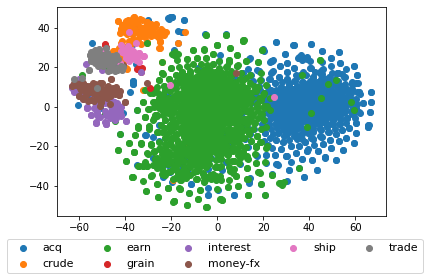

In [16]:
import os
import numpy as np
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

dataset = 'R8'
data_path = './data'

f = open(os.path.join(data_path, dataset + '.train.index'), 'r')
lines = f.readlines()
f.close()
train_size = len(lines)

f = open(os.path.join(data_path, dataset + '_shuffle.txt'), 'r')
lines = f.readlines()
f.close()

target_names = set()
labels = []
for line in lines:
    line = line.strip()
    temp = line.split('\t')
    labels.append(temp[2])
    target_names.add(temp[2])

target_names = list(target_names)

f = open(os.path.join(data_path, dataset + '_doc_vectors.txt'), 'r')
lines = f.readlines()
f.close()

docs = []
for line in lines:
    temp = line.strip().split()
    values_str_list = temp[1:]
    values = [float(x) for x in values_str_list]
    docs.append(values)

fea = docs[train_size:]
label = labels[train_size:]
label = np.array(label)

fea = TSNE(n_components=2).fit_transform(fea)
pdf = PdfPages(dataset + '_gcn_doc_test.pdf')
cls = np.unique(label)

fea_num = [fea[label == i] for i in cls]
for i, f in enumerate(fea_num):
    if cls[i] in range(10):
        plt.scatter(f[:, 0], f[:, 1], label=cls[i], marker='+')
    else:
        plt.scatter(f[:, 0], f[:, 1], label=cls[i])

plt.legend(ncol=5, loc='upper center', bbox_to_anchor=(0.48, -0.08), fontsize=11)
plt.tight_layout()
pdf.savefig()
plt.show()
pdf.close()